---
# 목차
---
* [1. 데이터 읽기](#Data-read)
* [2. setting](#settings)
* [3. 결측치처리](#결측치-처리)
* [4. train set / test set](#train-/-test-분할)
* [5. 모델링](#모델링-함수)
    * [5-1. 데이터 학습](#데이터-학습)
    * [5-2. 모델링 성능 확인](#모델링-성능-확인)
* [6. Rfecv](#rfecv)

---
# 캐글 커널 리뷰(모델링 및 stacking중심)
---


In [108]:
import pandas as pd
import numpy as np
from scipy.stats import skew
import xgboost as xgb
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from math import sqrt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
plt.style.use('ggplot') #ggplot스타일 사용
#한글폰트
plt.rc('font', family='nanumgothic')
plt.rc('axes', unicode_minus=False)

---
# Data read
---

In [156]:
data = pd.read_pickle('모델링데이터3주차.pkl')

In [212]:
data = pd.read_pickle('최인식.pkl')

In [240]:
data =pd.read_pickle('dongkyun.pkl')

In [8]:
data.dtypes.value_counts()

float64    272
int64       14
object      13
dtype: int64

In [20]:
data.select_dtypes('object').columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'AGE_RANGE'],
      dtype='object')

In [76]:
data.isnull().sum()

SK_ID_CURR                                              0
TARGET                                                  0
NAME_CONTRACT_TYPE                                      0
CODE_GENDER                                             0
FLAG_OWN_CAR                                            0
                                                    ...  
client_bureau_balance_STATUS_X_count_norm_count    215242
client_bureau_balance_STATUS_X_count_norm_mean     215242
client_bureau_balance_STATUS_X_count_norm_max      215242
client_bureau_balance_STATUS_X_count_norm_min      215242
client_bureau_balance_STATUS_X_count_norm_sum      215242
Length: 299, dtype: int64

---
# settings
---

In [236]:
'''factorizing = label encoding'''
NFOLDS = 3
SEED = 0
NROWS = None

categorical_feats = [
    f for f in data.columns if data[f].dtype == 'object'
]

for f_ in categorical_feats:
    data[f_], indexer = pd.factorize(data[f_])

In [237]:
data.dtypes.value_counts()

int64      43
float64    37
uint8      13
dtype: int64

In [214]:
data = data.select_dtypes(['float64','int64'])

In [227]:
'''3kfold 교차검증'''
kf = KFold(n_splits = NFOLDS, shuffle=True, random_state=SEED)

In [ ]:
'''binary encoding 처리하기'''

---
# 결측치 처리
---

---
### 방법1
---

In [228]:
data = data.replace(np.inf,np.nan)

In [232]:
def mis_val_treatment(data,string,percentage):
    """Treat the missing values.

    * This function select the features which have a number of missing values less than a given threshold
    * Numeric features : Replace missing values selected with mean/median of the feature
    * categorical features : Replace missing values with a new class named "missing value"

    :param data: data to treat
    :param string: mean/median
    :param percentage: percentage to define a threshold for missing values
    :return: data treated
    
    """
    var = data.isnull().sum()
    threshold = round(len(data.index) / percentage)#결측치가 30000만개 이하인 data를 선택
    data_mis_val = data[var[var!=0][var<threshold].index].copy()
    names_data = list(data_mis_val.columns.values)
    names_data_numeric = list(data_mis_val.describe().columns.values)
    
    for name in names_data:
        s = data_mis_val[name]
        if name in names_data_numeric:
            if string == "mean":
                s = s.fillna(s.mean())
            if string == "median":
                s = s.fillna(s.median())
        else:
            s = s.fillna("missing_value")
        data_mis_val[name] = s
        
    return data_mis_val

def data_model_constuct(data,data2):
    '''
    Reconstruct data after missing values treatment and one hot encoding

    :param data: data to reconstruct
    :param data2: result of mis val_treatment
    :return: data model constructed
    '''
    var = data.isnull().sum()
    data1 = data[var[var==0].index].copy()
    data_model = pd.concat([data1,data2],axis=1)
    #1. pd.get_dummies부분은 gender와 organization의 xna결측치를 처리해야함 , 사실상 포함해도되긴
    #하나 나중에 다시 고려해봐야지
    #2. 그리고 이미 getdummy를 한 상태라면 해당 코드의 줄은 없애도 됨
    #data_model = pd.get_dummies(data_model)
    return data_model

In [238]:
data_model = data_model_constuct(data,mis_val_treatment(data,'mean',1.5))

ValueError: Cannot describe a DataFrame without columns

In [204]:
len(data_model.columns)

182

In [162]:
data_model.isnull().sum().tolist()

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [219]:
data = data_model

---
### 방법2
---

In [155]:
data = data.replace(np.inf,np.nan)

In [ ]:
'''결측치를 해당 코드에서는 0으로 채움'''
data = data.fillna(0)

---
# train / test 분할
---

In [241]:
x_train, x_test, y_train, y_test = train_test_split(data.iloc[:,2:], 
                                                    np.array(data['TARGET'].tolist()),
                                                    test_size=0.3, 
                                                    stratify=np.array(data['TARGET'].tolist()),
                                                    random_state=123456)

---
# 모델링 함수
---

In [207]:
#----------------------------------모델링 객체 및 함수 정의-------------------------------------
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

class CatboostWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]
        
class LightGBMWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['feature_fraction_seed'] = seed
        params['bagging_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]


class XgbWrapper(object):
    #__init__는 객체에서 처음 받을 인자값을 선언한다.
    def __init__(self, clf ,seed=0, params=None):
        params['feature_fraction_seed'] = seed
        params['bagging_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

#----------------------------------------parameter 정의-------------------------------------
et_params = {
    'n_jobs': 16,
    'n_estimators': 200,
    'max_features': 0.5,
    'max_depth': 12,
    'min_samples_leaf': 2,
}

rf_params = {
    'n_jobs': 16,
    'n_estimators': 200,
    'max_features': 0.2,
    'max_depth': 12,
    'min_samples_leaf': 2,
}

xgb_params = {
    'seed': 0,
    'class_weight' : 'balanced',
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.075,
    'objective': 'binary:logistic',
    'max_depth': 4,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'nrounds': 200
}

catboost_params = {
    'iterations': 200,
    'learning_rate': 0.5,
    'depth': 3,
    'l2_leaf_reg': 40,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.7,
    'scale_pos_weight': 5,
    'eval_metric': 'AUC',
    'od_type': 'Iter',
    'allow_writing_files': False
}

lightgbm_params = {
    'n_estimators':200,
    'class_weight' : 'balanced',
    'learning_rate':0.1,
    'num_leaves':123,
    'colsample_bytree':0.8,
    'subsample':0.9,
    'max_depth':15,
    'reg_alpha':0.1,
    'reg_lambda':0.1,
    'min_split_gain':0.01,
    'min_child_weight':2    
}

---
### 데이터 학습
---

In [242]:
'''boost 기반 알고리즘은 결측치가 없이 돌아갈 수 있음
bagging기반 알고리즘은 결측치가 있으면 돌아가지 않음'''
xg = XgbWrapper(clf=xgb.XGBClassifier,seed=SEED, params=xgb_params)
et = SklearnWrapper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
rf = SklearnWrapper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
cb = CatboostWrapper(clf= CatBoostClassifier, seed = SEED, params=catboost_params)
lg = LightGBMWrapper(clf = LGBMClassifier, seed = SEED, params = lightgbm_params)

In [243]:
'''boosting'''
xg.train(x_train,y_train)
cb.train(x_train,y_train)
lg.train(x_train,y_train)

0:	total: 40.4ms	remaining: 8.04s
1:	total: 74.8ms	remaining: 7.41s
2:	total: 107ms	remaining: 7.02s
3:	total: 138ms	remaining: 6.76s
4:	total: 167ms	remaining: 6.53s
5:	total: 203ms	remaining: 6.55s
6:	total: 241ms	remaining: 6.64s
7:	total: 286ms	remaining: 6.88s
8:	total: 324ms	remaining: 6.88s
9:	total: 361ms	remaining: 6.87s
10:	total: 393ms	remaining: 6.75s
11:	total: 423ms	remaining: 6.62s
12:	total: 475ms	remaining: 6.84s
13:	total: 515ms	remaining: 6.84s
14:	total: 547ms	remaining: 6.74s
15:	total: 580ms	remaining: 6.67s
16:	total: 618ms	remaining: 6.65s
17:	total: 652ms	remaining: 6.59s
18:	total: 703ms	remaining: 6.7s
19:	total: 745ms	remaining: 6.71s
20:	total: 785ms	remaining: 6.69s
21:	total: 826ms	remaining: 6.68s
22:	total: 877ms	remaining: 6.75s
23:	total: 931ms	remaining: 6.83s
24:	total: 982ms	remaining: 6.87s
25:	total: 1.02s	remaining: 6.82s
26:	total: 1.07s	remaining: 6.84s
27:	total: 1.13s	remaining: 6.94s
28:	total: 1.19s	remaining: 7.04s
29:	total: 1.23s	remain

In [245]:
'''bagging기반 tree모델'''
rf.train(x_train,y_train)
et.train(x_train,y_train)

---
### 모델링 성능 확인
---

In [193]:
'''부스팅 모델 성능확인'''
def BT_model_comparison(x_test,y_test):
    ts = xg.predict(x_test) #xgb
    ts1 = cb.predict(x_test) #ctb
    ts2 = lg.predict(x_test) #lgb
    
    [fpr, tpr, thr] = metrics.roc_curve(y_test, ts)
    [fpr2,tpr2,thr2] = metrics.roc_curve(y_test, ts1)
    [fpr3,tpr3,thr3] = metrics.roc_curve(y_test, ts2)
    
    auc = metrics.auc(fpr, tpr)
    auc2 = metrics.auc(fpr2, tpr2)
    auc3 = metrics.auc(fpr3, tpr3)
    
    print('xgboost 모델 auc면적 : ' , auc)
    print('catboost 모델 auc면적 : ' , auc2)
    print('lightgradientboost 모델 auc면적 : ' , auc3)
    
    model = ['xgb','ctb','lgb']
    auc = [auc,auc2,auc3]
    error = np.random.rand(len(model))
    
    for i in range(len(auc)):
        if auc[i] == max(auc):
            max_index = i
    
    plt.figure(figsize=(15,8))
    plt.title('model comparison')
    plt.barh(model,auc,xerr=error)
    plt.yticks(model,fontsize=10)
    plt.ylabel('모델명',fontsize=10)
    plt.show()

    print(model[max_index]+' 모델이 가장 좋은 성능을 보였습니다.')

'''bagging기반 모델 성능 확인'''
def BG_model_comparison(x_test,y_test):
    ts3 = rf.predict(x_test) #rf
    ts4 = et.predict(x_test) #extract  
    
    [fpr3, tpr3, thr3] = metrics.roc_curve(y_test, ts3)
    [fpr4,tpr4,thr4] = metrics.roc_curve(y_test, ts4)
    
    auc3 = metrics.auc(fpr3, tpr3)
    auc4 = metrics.auc(fpr4, tpr4)
        
    print('xgboost 모델 auc면적 : ' , auc3)
    print('catboost 모델 auc면적 : ' , auc4)
    
    model = ['RF','ET']
    auc = [auc3,auc4]
    error = np.random.rand(len(model))
    
    for i in range(len(auc)):
        if auc[i] == max(auc):
            max_index = i
    
    plt.figure(figsize=(15,8))
    plt.title('model comparison')
    plt.barh(model,auc,xerr=error)
    plt.yticks(model,fontsize=10)
    plt.ylabel('모델명',fontsize=10)
    plt.show()

    print(model[max_index]+' 모델이 가장 좋은 성능을 보였습니다.')

xgboost 모델 auc면적 :  0.7582325524311164
catboost 모델 auc면적 :  0.7672681283681659
lightgradientboost 모델 auc면적 :  0.7562658910652988


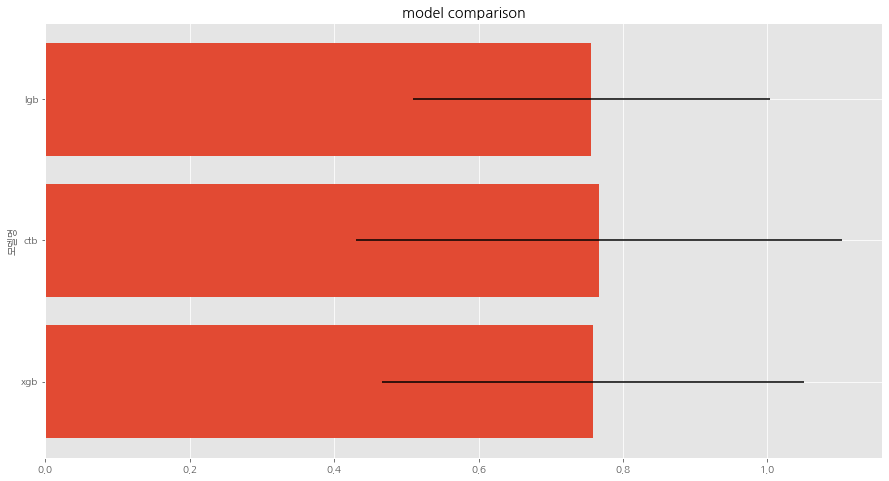

ctb 모델이 가장 좋은 성능을 보였습니다.


In [184]:
BT_model_comparison(x_test,y_test)

xgboost 모델 auc면적 :  0.7545530901538515
catboost 모델 auc면적 :  0.7626854019864077
lightgradientboost 모델 auc면적 :  0.753588716084753


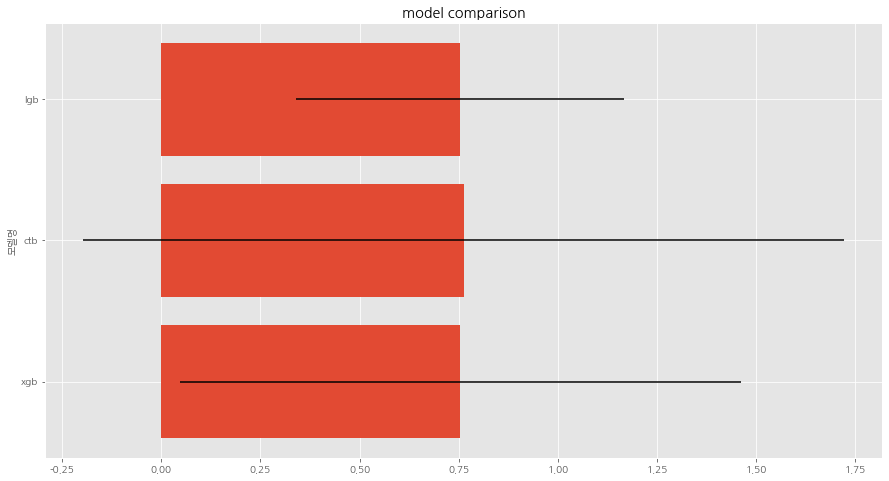

ctb 모델이 가장 좋은 성능을 보였습니다.


In [223]:
'''인식님'''
BT_model_comparison(x_test,y_test)

xgboost 모델 auc면적 :  0.7510015509298554
catboost 모델 auc면적 :  0.7468608946729666
lightgradientboost 모델 auc면적 :  0.7209155545254892


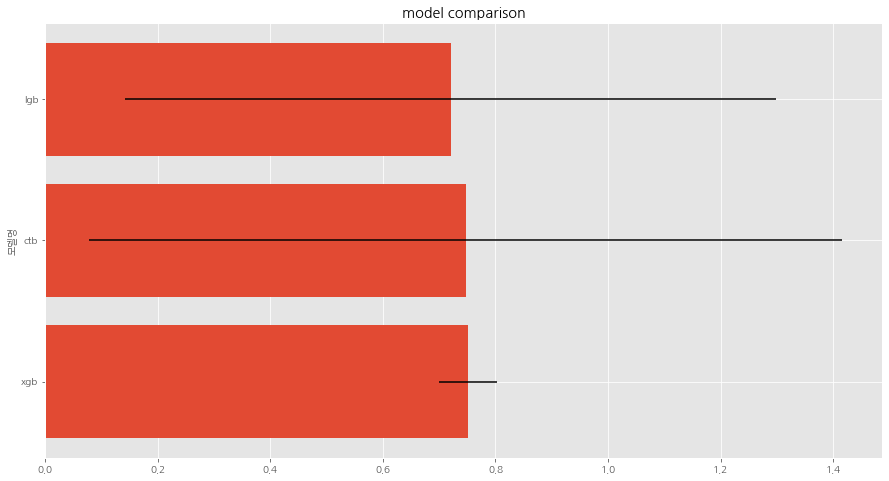

xgb 모델이 가장 좋은 성능을 보였습니다.


In [244]:
'''동균님'''
BT_model_comparison(x_test,y_test)

xgboost 모델 auc면적 :  0.7426439698351794
catboost 모델 auc면적 :  0.7430675531500377


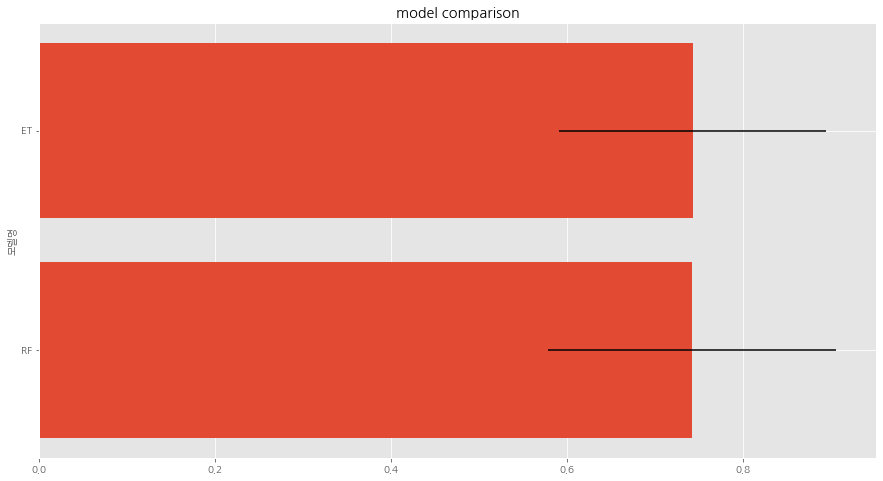

ET 모델이 가장 좋은 성능을 보였습니다.


In [195]:
BG_model_comparison(x_test,y_test)

xgboost 모델 auc면적 :  0.7402701972730985
catboost 모델 auc면적 :  0.7413982421367129


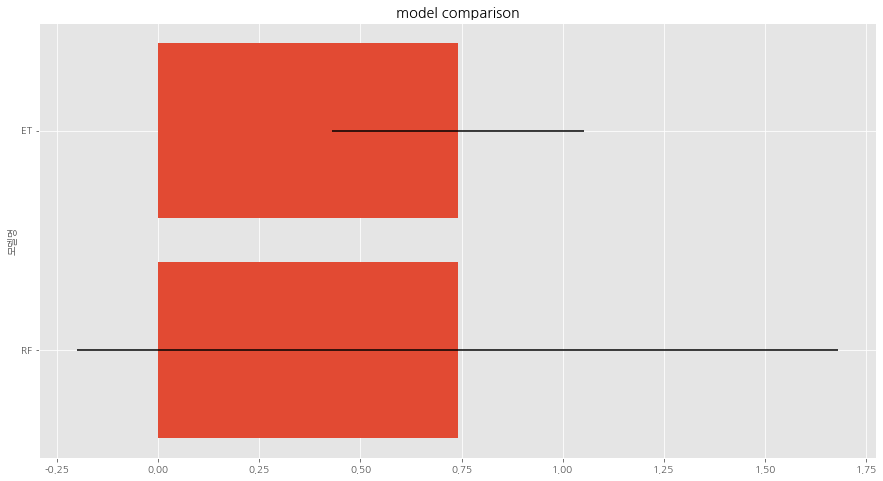

ET 모델이 가장 좋은 성능을 보였습니다.


In [246]:
'''동균님'''
BG_model_comparison(x_test,y_test)

---
# rfecv
---

In [176]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [185]:
lgb_model = LGBMClassifier(n_estimators=200,class_weight='balanced',learning_rate=0.1,
                           num_leaves=123, colsample_bytree=0.8,subsample=0.9,max_depth=15,
                          reg_alpha=0.1,reg_lambda=0.1,min_split_gain=0.01,minchild_weight=2)
cat_model = CatBoostClassifier(iterations=200,
    learning_rate = 0.5,
    depth = 3,
    l2_leaf_reg =  40,
    bootstrap_type = 'Bernoulli',
    subsample=  0.7,
    scale_pos_weight = 5,
    eval_metric = 'AUC',
    od_type ='Iter',
    allow_writing_files = False)
xgb_model = xgb.XGBClassifier(seed= 0,
    class_weight = 'balanced',
    colsample_bytree= 0.7,
    silent= 1,
    subsample= 0.7,
    learning_rate= 0.075,
    objective= 'binary:logistic',
    max_depth= 4,
    num_parallel_tree= 1,
    min_child_weight= 1,
    nrounds= 200)

In [190]:
boost_model = [lgb_model,cat_model,xgb_model]

In [191]:
'''feature selection의 시간이 굉장히 오래걸림'''
for i in boost_model:
    selector = RFECV(estimator=i, step=3, 
               cv=3, scoring='roc_auc')
    
    selector.fit(x_train, y_train)
    
    plt.figure(figsize=(15,10))
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (roc auc)")
    plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
    plt.show()

    rankings = pd.DataFrame({'feature': list(x_train.columns), 'rank': list(selector.ranking_)}).sort_values('rank')

KeyboardInterrupt: 